<a href="https://colab.research.google.com/github/seansothey/MyProject/blob/master/XGBoost_Census_Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://miro.medium.com/max/1000/1*08ltbgXFxujakJZSJswp1Q.png)

**Data Set Information:**

Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

*Prediction task is to determine whether a person makes over 50K a year.*


**Attribute Information:**

* >50K, <=50K.

* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



#Setup and load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import warnings
warnings.filterwarnings(action="ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("/content/adult.csv", skipinitialspace=True) #skipinitialspace use to avoid space
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-per-year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


#Data Scrubing

In [4]:
#!pip install -U pandas-profiling

In [5]:
# Run data profile quick and effecient
from pandas_profiling import ProfileReport

df_profile = df.profile_report(title='Cencus Income')
df_profile

In [6]:
# Save data profile to HTML
df_profile.to_file("Cencus_Income.html")

From the summary above, there is no missing cell.
The value 0 in capital-gain column has 91.7% and capital-loss has 95.3%, therefore this two columns are not useful at all.

The class column income-per-year <=50K has 75.9% and >50k has 24.1%, this may cause imbalancing.

Some columns has missing value as '?', described below:
* workclass = 5.6%
* occupation = 5.7%
* native-country = 1.8%

These missing value shall be removed it's not higher than 10% each.

There's no high correlation between each attribute; therefore all shall be used for prediction.

In [7]:
df.drop(['capital-gain', 'capital-loss'], inplace=True, axis=1)

In [8]:
# drop all "?" value
df = df[(df != '?').all(axis=1)]

In [9]:
df.isin(['?']).sum()

age                0
workclass          0
fnlwgt             0
education          0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
hours-per-week     0
native-country     0
income-per-year    0
dtype: int64

There's no more missing value!

In [10]:
# Create X and y
X = df.drop('income-per-year', axis=1)
y = df['income-per-year']

In [11]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba


In [12]:
# Convert categorical value
X['sex'] = X['sex'].map({'Male': 1, 'Female': 0})

In [13]:
X = pd.get_dummies(X)
X.head()

,age,fnlwgt,education-num,sex,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,1,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,13,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
y.head(10)

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
5    <=50K
6    <=50K
7     >50K
8     >50K
9     >50K
Name: income-per-year, dtype: object

In [15]:
y = y.map({'<=50K':0, '>50K':1})
y.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income-per-year, dtype: int64

In [16]:
# Spliting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify is used to keep the same ration of y label (76%-24%)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24129, 101), (24129,), (6033, 101), (6033,))

#Building a basic model

In [18]:
model = xgb.XGBClassifier(seed=42)

In [19]:
model.fit(X_train,
          y_train,
          early_stopping_rounds=10, #xgboost will stop when no improvement after build 10 more trees 
          eval_metric='aucpr',
          eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.621533
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.635437
[2]	validation_0-aucpr:0.647539
[3]	validation_0-aucpr:0.655101
[4]	validation_0-aucpr:0.655777
[5]	validation_0-aucpr:0.656373
[6]	validation_0-aucpr:0.669293
[7]	validation_0-aucpr:0.671065
[8]	validation_0-aucpr:0.6733
[9]	validation_0-aucpr:0.673777
[10]	validation_0-aucpr:0.678591
[11]	validation_0-aucpr:0.690299
[12]	validation_0-aucpr:0.689508
[13]	validation_0-aucpr:0.690738
[14]	validation_0-aucpr:0.693788
[15]	validation_0-aucpr:0.694603
[16]	validation_0-aucpr:0.695752
[17]	validation_0-aucpr:0.697797
[18]	validation_0-aucpr:0.698863
[19]	validation_0-aucpr:0.699437
[20]	validation_0-aucpr:0.700059
[21]	validation_0-aucpr:0.701865
[22]	validation_0-aucpr:0.702221
[23]	validation_0-aucpr:0.702886
[24]	validation_0-aucpr:0.703029
[25]	validation_0-aucpr:0.703422
[26]	validation_0-aucpr:0.703545
[27]	validation_0-aucpr:0.704095
[28]	validation_0-aucp

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

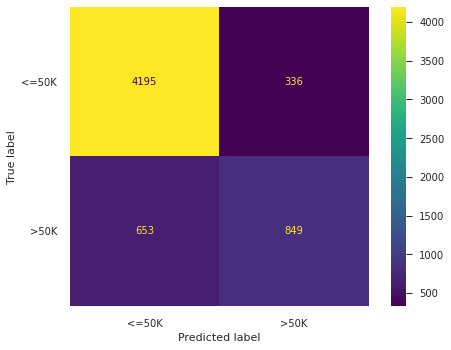

In [20]:
# Plot confusion matrix
plot_confusion_matrix(model,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["<=50K", ">50K"])

In [21]:
# see the accuracy
model.score(X_test, y_test)

0.8360682910658047

In [22]:
# see the classification report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.89      4531
           1       0.72      0.57      0.63      1502

    accuracy                           0.84      6033
   macro avg       0.79      0.75      0.76      6033
weighted avg       0.83      0.84      0.83      6033



As expected, the model doesn't work well on classifying income >50K because of very low existance. 
Let's improve the model by optimizing the hyperparameters and imbalance techniques.

#Hyperparameters Optimization

In [53]:
param_grid = {
    'max_depth': range(2, 8),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': range(20, 220, 20),
    'gamma': [0, 0.05, 0.1],
    'subsample': [0.7],
    'reg_alpha': [0.9],
    'reg_lambda': [0.9]
}

In [54]:
model_gs = GridSearchCV(estimator=model,
                        param_grid = param_grid,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=3,
                        verbose=True)

In [55]:
model_gs.fit(X_train,
             y_train,
             eval_metric='aucpr',
             verbose=True)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1170 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  7.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'gamma': [0, 0.05, 0.1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': range(2, 8),
                   

In [56]:
best_model = model_gs.best_estimator_
print(best_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.05,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.9, reg_lambda=0.9, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.7, verbosity=1)


In [58]:
# see the best model accuracy
best_model.score(X_test, y_test)

0.8397149013757667

After hyperparameters tuning, the accuracy has improved very slighly.